# Gesture Controlled Music Recommendation and Real-Time Mood Detection System

    1) Problem Definition & Objective
a) Recommendation System + Computer Vision 

b) Traditional music recommendation systems rely heavily on user input such as clicks, searches or listening history, Also users cannot provide the inputs from a distance.

The problem addressed in this project is to design an intelligent system that can:

> Detect a user’s mood in real time

> Capture feedbacks using hand gestures from a distance

> Generate personalized music recommendations.

c) Music streaming platforms aim to personalize user experience, but most systems ignore real-time emotional context and to use the platform while performing other tasks such as, while cooking it is better to provide a gesture than to operate controls manually .

This project is motivated by :

>Emotion-aware AI systems

>Accessibility (hands-free interaction)

>Real-time personalization

Such systems are relevant in:

>Smart entertainment systems

>Fitness & wellness applications

>And In Multiple Applications....


        importing neccessary libraries

In [27]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from collections import deque
import time
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

    2) Data Understanding & Preparation
a) Dataset Source : https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset . This is Public Dataset with multiple features. Like : Energy ,Valence ,Danceability,Tempo ,Acousticness , Loudness, Popularity

b) The dataset is loaded using Pandas and exploratory analysis is performed : 

 >Dataset size and unique tracks

 >Genre and artist distribution

 >Descriptive statistics of audio features

 >Sample song inspection

This ensures understanding of feature ranges and data quality.

c) Cleaning, Preprocessing & Feature Engineering

The following preprocessing steps are applied :

 >Column renaming for consistency

 >Removal of duplicate song IDs

 >Selection of relevant audio features

 >Feature normalization using StandardScaler

 >Feature vector preparation for similarity computation

d) Handling Missing Values / Noise :

 >Numerical missing values are filled using median imputation

 >Text fields (artist, genre) are filled with placeholder values

 >Dataset integrity is preserved for recommendation accuracy


In [28]:
# Class for Loading and Preprocessing Spotify dataset


def load_spotify_dataset(filepath='dataset.csv', sample_size=5000): 
    """
    Load and preprocess Spotify dataset
    
    Args:
        filepath: Path to the Spotify CSV file
        sample_size: Number of songs to use (None for all)
    """
    print("Loading Spotify dataset...")
    
    # Load dataset
    df = pd.read_csv(filepath)
    
    print(f"Loaded {len(df)} tracks")
    
    # Select sample if needed (for faster processing)
    if sample_size and len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
        print(f"Using sample of {sample_size} tracks")
    
    # Rename columns to match our system
    column_mapping = {
        'track_id': 'song_id',
        'track_name': 'song_name',
        'artists': 'artist',
        'album_name': 'album',
        'track_genre': 'genre'
        # energy, valence, danceability, etc. already have correct names
    }
    
    df = df.rename(columns=column_mapping)
    
    # Select required columns
    required_cols = [
        'song_id', 'song_name', 'artist', 'genre',
        'energy', 'valence', 'danceability', 'tempo',
        'acousticness', 'instrumentalness', 'loudness',
        'popularity'
    ]
    
    # Check which columns exist
    available_cols = [col for col in required_cols if col in df.columns]
    df = df[available_cols]
    
    # Handle missing values
    print(" Cleaning data...")
    
    # Fill missing numerical values with median
    numerical_cols = ['energy', 'valence', 'danceability', 'tempo',
                      'acousticness', 'instrumentalness', 'loudness']
    
    for col in numerical_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    # Fill missing text values
    if 'artist' in df.columns:
        df['artist'] = df['artist'].fillna('Unknown Artist')
    if 'genre' in df.columns:
        df['genre'] = df['genre'].fillna('Unknown')
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['song_id'])
    
    # Reset index
    df = df.reset_index(drop=True)
    
    print(f"Final dataset: {len(df)} unique tracks")
    print(f"Genres: {df['genre'].nunique()}")
    print(f" Artists: {df['artist'].nunique()}")
    
    # Show sample
    print("\n Sample songs:")
    print(df[['song_name', 'artist', 'energy', 'valence']].head())
    
    # Show statistics
    print("\n Audio Feature Statistics:")
    print(df[numerical_cols].describe())
    
    return df

# Loading the dataset
# Using sample_size of 5000 

songs_df = load_spotify_dataset(r'dataset.csv', sample_size=5000)


Loading Spotify dataset...
Loaded 114000 tracks
Using sample of 5000 tracks
 Cleaning data...
Final dataset: 4937 unique tracks
Genres: 114
 Artists: 3793

 Sample songs:
               song_name                      artist  energy  valence
0          No Other Name            Hillsong Worship   0.598   0.0466
1         Failed Organum                Internal Rot   0.997   0.0294
2  Save the Trees, Pt. 1  Zhoobin Askarieh;Ali Sasha   0.803   0.0887
3        Merry Christmas                 Bryan Adams   0.511   0.5980
4                  月の大きさ                  Nogizaka46   0.941   0.8130

 Audio Feature Statistics:
            energy      valence  danceability        tempo  acousticness  \
count  4937.000000  4937.000000   4937.000000  4937.000000   4937.000000   
mean      0.645201     0.469381      0.562940   122.652349      0.313913   
std       0.252360     0.261545      0.175052    29.798509      0.333558   
min       0.000020     0.000000      0.000000     0.000000      0.000000   
2

    3) Model / System Design
a) This project uses a Hybrid AI System, combining :

 >Computer Vision (MediaPipe hand tracking)

 >Rule-based gesture recognition

 >Content-based recommendation (cosine similarity)

 >Neural Collaborative Filtering (PyTorch)

 >Real-time mood inference

b) Architecture / Pipeline :

[ Webcam → Gesture Detection → Mood Inference ]
                ↓
[ User Feedback (Like/Dislike/Skip/GestureSpeed) ]
                ↓
    [ Recommendation Engine ]
                ↓
    [ Personalized Song Output ]

Main components:

 >GestureDetector: detects hand gestures and        movement-based mood

 >MusicRecommender: generates recommendations

 >Real-time application loop with webcam input

c) Justification of Design Choices :

 >MediaPipe: lightweight and real-time capable

 >Cosine similarity: effective for audio feature matching

 >Hybrid recommender: handles cold-start and personalization

 >Gesture input:  natural and user-friendly

 >Modular design: scalable and easy to extend


In [29]:
# GESTURE DETECTION ENGINE:
# This class will detect gestures and convert them to mood based features and by using these features in our recommendation engine , it will  recommend songs.

class GestureDetector:
    """Hand gesture recognition using MediaPipe"""
    
    def __init__(self):
        # Initialize MediaPipe
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.7,
            min_tracking_confidence=0.5
        )
        self.mp_draw = mp.solutions.drawing_utils
        
        # Movement tracking for mood detection
        self.hand_positions = deque(maxlen=10)
        self.last_gesture_time = time.time()
        self.gesture_cooldown = 1.5
    
    def detect_thumbs_up(self, hand_landmarks):
        """Detect thumbs up gesture"""
        thumb_tip = hand_landmarks.landmark[4]
        thumb_ip = hand_landmarks.landmark[3]
        index_mcp = hand_landmarks.landmark[5]
        
        thumb_extended = thumb_tip.y < thumb_ip.y < index_mcp.y
        index_curled = hand_landmarks.landmark[8].y > index_mcp.y
        middle_curled = hand_landmarks.landmark[12].y > hand_landmarks.landmark[9].y
        
        return thumb_extended and index_curled and middle_curled
    
    def detect_thumbs_down(self, hand_landmarks):
        """Detect thumbs down gesture"""
        thumb_tip = hand_landmarks.landmark[4]
        thumb_ip = hand_landmarks.landmark[3]
        index_mcp = hand_landmarks.landmark[5]
        
        thumb_extended = thumb_tip.y > thumb_ip.y > index_mcp.y
        index_curled = hand_landmarks.landmark[8].y > index_mcp.y
        
        return thumb_extended and index_curled
    
    def detect_open_palm(self, hand_landmarks):
        """Detect open palm (all fingers extended)"""
        fingers_extended = 0
        
        if hand_landmarks.landmark[4].x > hand_landmarks.landmark[3].x:
            fingers_extended += 1
        
        finger_tips = [8, 12, 16, 20]
        finger_pips = [6, 10, 14, 18]
        
        for tip, pip in zip(finger_tips, finger_pips):
            if hand_landmarks.landmark[tip].y < hand_landmarks.landmark[pip].y:
                fingers_extended += 1
        
        return fingers_extended >= 4
    
    def detect_peace_sign(self, hand_landmarks):
        """Detect peace/victory sign"""
        index_extended = hand_landmarks.landmark[8].y < hand_landmarks.landmark[5].y
        middle_extended = hand_landmarks.landmark[12].y < hand_landmarks.landmark[9].y
        ring_curled = hand_landmarks.landmark[16].y > hand_landmarks.landmark[13].y
        pinky_curled = hand_landmarks.landmark[20].y > hand_landmarks.landmark[17].y
        
        return index_extended and middle_extended and ring_curled and pinky_curled
    
    def calculate_hand_speed(self, hand_landmarks):
        """Calculate hand movement speed for mood detection"""
        wrist_pos = (hand_landmarks.landmark[0].x, hand_landmarks.landmark[0].y)
        self.hand_positions.append(wrist_pos)
        
        if len(self.hand_positions) < 2:
            return 0
        
        speeds = []
        for i in range(1, len(self.hand_positions)):
            prev = self.hand_positions[i-1]
            curr = self.hand_positions[i]
            speed = np.sqrt((curr[0] - prev[0])**2 + (curr[1] - prev[1])**2)
            speeds.append(speed)
        
        return np.mean(speeds) if speeds else 0
    
    def detect_mood_from_movement(self, hand_landmarks):
        """Detect mood based on hand movement patterns"""
        speed = self.calculate_hand_speed(hand_landmarks)
        
        if speed > 0.05:
            return "energetic"
        elif speed > 0.02:
            return "happy"
        elif speed > 0.01:
            return "calm"
        else:
            return "relaxed"
    
    def process_frame(self, frame):
        """Process a single frame and detect gestures"""
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.hands.process(rgb_frame)
        
        gesture = None
        mood = "neutral"
        confidence = 0.0
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw hand landmarks
                self.mp_draw.draw_landmarks(
                    frame, hand_landmarks, self.mp_hands.HAND_CONNECTIONS,
                    self.mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2),
                    self.mp_draw.DrawingSpec(color=(255, 0, 0), thickness=2)
                )
                
                # Detect mood
                mood = self.detect_mood_from_movement(hand_landmarks)
                
                # Check gesture cooldown
                current_time = time.time()
                if current_time - self.last_gesture_time < self.gesture_cooldown:
                    continue
                
                # Detect gestures
                if self.detect_thumbs_up(hand_landmarks):
                    gesture = "thumbs_up"
                    confidence = 0.9
                    self.last_gesture_time = current_time
                elif self.detect_thumbs_down(hand_landmarks):
                    gesture = "thumbs_down"
                    confidence = 0.9
                    self.last_gesture_time = current_time
                elif self.detect_peace_sign(hand_landmarks):
                    gesture = "peace"
                    confidence = 0.85
                    self.last_gesture_time = current_time
                elif self.detect_open_palm(hand_landmarks):
                    gesture = "open_palm"
                    confidence = 0.8
                    self.last_gesture_time = current_time
        
        return frame, gesture, mood, confidence


# Gesture to action mapping
GESTURE_ACTIONS = {
    "thumbs_up": "like",
    "thumbs_down": "dislike",
    "open_palm": "skip",
    "peace": "favorite",
}

# Mood to audio feature mapping
MOOD_FEATURES = {
    "energetic": {"energy": 0.8, "valence": 0.7, "tempo": 140},
    "happy": {"energy": 0.6, "valence": 0.8, "tempo": 120},
    "calm": {"energy": 0.3, "valence": 0.5, "tempo": 90},
    "relaxed": {"energy": 0.2, "valence": 0.6, "tempo": 80},
    "neutral": {"energy": 0.5, "valence": 0.5, "tempo": 110}
}

print("Gesture Detector initialized!")

Gesture Detector initialized!


    4) Core Implementation

a) Model Training / Inference Logic :

 >Collaborative Filtering model implemented using PyTorch

 >User and song embeddings learned 

 >Neural network refines interaction prediction

 >Content-based filtering used for real-time inference

b) Recommendation Pipeline :

 >Detect user gesture

 >Map gesture to action (like, dislike, skip , peace)

 >Infer mood from hand movement speed

 >Update user preference history

 >Filter songs based on mood

 >Rank songs using similarity

 >Output next recommendation

c) Code Execution :

 >Notebook runs top-to-bottom without errors

 >Webcam-based execution tested

 >Handles cold-start and missing gesture cases gracefully

In [30]:
# MUSIC RECOMMENDATION ENGINE:
# Now this the main asset of our project as here we have Collaborative filter model and the music recommender model classes.

class CollaborativeFilteringModel(nn.Module):
    """Neural Collaborative Filtering with PyTorch"""
    
    def __init__(self, n_users, n_songs, embedding_dim=50):
        super(CollaborativeFilteringModel, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.song_embedding = nn.Embedding(n_songs, embedding_dim)
        self.user_bias = nn.Embedding(n_users, 1)
        self.song_bias = nn.Embedding(n_songs, 1)
        
        # Neural Network layers
        self.network = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.song_embedding.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.song_bias.weight)
    
    def forward(self, user_ids, song_ids):
        user_emb = self.user_embedding(user_ids)
        song_emb = self.song_embedding(song_ids)
        concat = torch.cat([user_emb, song_emb], dim=1)
        network_output = self.network(concat)
        prediction = network_output + self.user_bias(user_ids) + self.song_bias(song_ids)
        return prediction.squeeze()


class MusicRecommender:
    """Complete music recommendation system"""
    
    def __init__(self, songs_df):
        print("Initializing Music Recommender...")
        
        self.songs_df = songs_df
        
        # Create mappings
        self.song_to_idx = {song_id: idx for idx, song_id in enumerate(songs_df['song_id'])}
        self.idx_to_song = {idx: song_id for song_id, idx in self.song_to_idx.items()}
        
        # User management
        self.user_to_idx = {}
        self.idx_to_user = {}
        self.next_user_idx = 0
        
        # Audio features for content-based filtering
        self.scaler = StandardScaler()
        self.audio_features = ['energy', 'valence', 'danceability', 'tempo',
                               'acousticness', 'instrumentalness', 'loudness']
        
        # Prepare features
        self._prepare_features()
        
        # Model
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print(f" Recommender ready with {len(songs_df)} songs")
    
    def _prepare_features(self):
        """Normalize audio features for similarity calculation"""
        feature_matrix = self.songs_df[self.audio_features].fillna(0).values
        self.normalized_features = self.scaler.fit_transform(feature_matrix)
        print(" Audio features normalized")
    
    def init_model(self):
        """Initialize collaborative filtering model"""
        n_users = max(len(self.user_to_idx), 1)
        n_songs = len(self.song_to_idx)
        self.model = CollaborativeFilteringModel(n_users, n_songs).to(self.device)
        print(" Collaborative filtering model initialized")
    
    def content_based_recommend(self, liked_song_ids, mood_features=None, n_recommendations=10):
        """
        Content-based recommendations using audio features

        WORKFLOW:
        1. Gets audio features of songs user liked
        2. Calculate average feature profile
        3. Find similar songs using cosine similarity
        4. Filter by mood if provided
        5. Return top N recommendations
        """
        # Cold start: no liked songs yet
        if not liked_song_ids:
            return self._get_popular_by_mood(mood_features, n_recommendations)
        
        # Get indices of liked songs
        liked_indices = [self.song_to_idx[sid] for sid in liked_song_ids 
                        if sid in self.song_to_idx]
        
        if not liked_indices:
            return self._get_popular_by_mood(mood_features, n_recommendations)
        
        # Calculate average features of liked songs
        liked_features = self.normalized_features[liked_indices]
        avg_profile = np.mean(liked_features, axis=0).reshape(1, -1)
        
        # Calculate similarity with all songs
        similarities = cosine_similarity(avg_profile, self.normalized_features)[0]
        
        # Apply mood filter if provided
        if mood_features:
            mood_mask = self._get_mood_mask(mood_features)
            similarities = similarities * mood_mask
        
        # Get top N
        top_indices = np.argsort(similarities)[::-1]
        
        recommendations = []
        for idx in top_indices:
            song_id = self.idx_to_song[idx]
            if song_id not in liked_song_ids:  # Don't recommend already liked songs
                song_data = self.songs_df[self.songs_df['song_id'] == song_id].iloc[0]
                recommendations.append({
                    'song_id': song_id,
                    'song_name': song_data['song_name'],
                    'artist': song_data['artist'],
                    'score': float(similarities[idx]),
                    'energy': song_data['energy'],
                    'valence': song_data['valence']
                })
            
            if len(recommendations) >= n_recommendations:
                break
        
        return recommendations
    
    def _get_mood_mask(self, mood_features):
        """Create filter mask based on mood"""
        mask = np.ones(len(self.songs_df))
        
        if 'energy' in mood_features:
            target = mood_features['energy']
            energy_vals = self.songs_df['energy'].values
            mask *= (np.abs(energy_vals - target) < 0.3).astype(float)
        
        if 'valence' in mood_features:
            target = mood_features['valence']
            valence_vals = self.songs_df['valence'].values
            mask *= (np.abs(valence_vals - target) < 0.3).astype(float)
        
        return mask
    
    def _get_popular_by_mood(self, mood_features, n):
        """Get popular songs matching mood (for cold start)"""
        filtered_df = self.songs_df.copy()
        
        if mood_features:
            if 'energy' in mood_features:
                e_target = mood_features['energy']
                filtered_df = filtered_df[
                    (filtered_df['energy'] >= e_target - 0.3) &
                    (filtered_df['energy'] <= e_target + 0.3)
                ]
            
            if 'valence' in mood_features:
                v_target = mood_features['valence']
                filtered_df = filtered_df[
                    (filtered_df['valence'] >= v_target - 0.3) &
                    (filtered_df['valence'] <= v_target + 0.3)
                ]
        
        # Get most popular
        if 'popularity' in filtered_df.columns and len(filtered_df) > 0:
            top_songs = filtered_df.nlargest(min(n * 2, len(filtered_df)), 'popularity')
            top_songs = top_songs.sample(min(n, len(top_songs)))
        else:
            top_songs = filtered_df.sample(min(n, len(filtered_df)))
        
        recommendations = []
        for _, row in top_songs.iterrows():
            recommendations.append({
                'song_id': row['song_id'],
                'song_name': row['song_name'],
                'artist': row['artist'],
                'score': 1.0,
                'energy': row['energy'],
                'valence': row['valence']
            })
        
        return recommendations[:n]


print(" Music Recommender class ready!")

 Music Recommender class ready!


    Initializing the classes

In [31]:
# Initialize recommender with Spotify data

recommender = MusicRecommender(songs_df)
recommender.init_model()

# Initialize gesture detector
detector = GestureDetector()

# User session storage
user_session = {
    'user_id': 'user_001',
    'liked_songs': [],
    'disliked_songs': [],
    'current_song': None,
    'interactions': []
}

print("\n" + "="*70)
print(" SYSTEM READY!")
print("="*70)
print(f" {len(songs_df)} Spotify tracks loaded")
print(f" Gesture detector active")
print(f" Recommendation engine initialized")
print("="*70)

Initializing Music Recommender...
 Audio features normalized
 Recommender ready with 4937 songs
 Collaborative filtering model initialized

 SYSTEM READY!
 4937 Spotify tracks loaded
 Gesture detector active
 Recommendation engine initialized


    5)Evaluation & Analysis

a) Metrics Used :

Since this is an interactive AI system, qualitative evaluation is used:

 >User feedback (likes/dislikes)

 >Session interaction count

 >Mood distribution

 >Gesture frequency

 >Recommendation diversity

b) Sample Outputs

 >Real-time song recommendations

 >On-screen display of:

 >Mood ,Current song ,Detected gesture

 >Session analytics plots

 >CSV export of interaction history

c) Performance Analysis & Limitations

Strengths:

 >Real-time responsiveness

 >Emotion-aware recommendations

 >Natural interaction

Limitations:

 >Single-user system

 >Mood inference is heuristic-based
 
 >Depends on webcam quality and lighting



In [32]:

# This is Custom Designed Dashboard with Diverse Graphs for error less inference.

# MANUAL :
"""
    WORKFLOW:
    1. Open webcam
    2. Show initial recommendation
    3. Detect gestures and mood:

       Gestures: 👍=Like 👎=Dislike ✋=Skip ✌️=Favorite
       Mood : Speed of gesture Movement classifies to following moods : { Energetic, Happy, Calm , Neutral  }

    4. Update preferences based on gestures 
    5. Generate new recommendations
    6. Display statistics
"""

def run_moodtune(duration=30):
    
    print("="*70)
    print("🎵  GESTURE-CONTROLLED MUSIC RECOMMENDER")
    print("="*70)
    print(f"\n⏱️  Running for {duration} seconds")
    print("👋 Gestures: 👍=Like 👎=Dislike ✋=Skip ✌️=Favorite")
    print("="*70)
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print(" Cannot access webcam!")
        return user_session
    
    # Get initial recommendation
    print("\n🎵 Getting initial recommendations...")
    mood_features = MOOD_FEATURES['neutral']
    initial_recs = recommender.content_based_recommend([], mood_features, 10)
    
    if initial_recs:
        user_session['current_song'] = initial_recs[0]
        print(f"▶️  Now Playing: {initial_recs[0]['song_name']}")
        print(f"   Artist: {initial_recs[0]['artist']}\n")
    
    start_time = time.time()
    current_mood = "neutral"
    last_gesture = None
    
    # Main loop
    while time.time() - start_time < duration:
        ret, frame = cap.read()
        if not ret:
            break
        
        #  Process frame for gestures and mood
        processed_frame, gesture, mood, confidence = detector.process_frame(frame)
        
        if mood:
            current_mood = mood
        
        # Display info on frame
        cv2.putText(processed_frame, f"Mood: {current_mood}", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        if user_session['current_song']:
            song_display = user_session['current_song']['song_name'][:35]
            cv2.putText(processed_frame, f"Playing: {song_display}", 
                        (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        if gesture:
            cv2.putText(processed_frame, f"Gesture: {gesture}", 
                        (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        cv2.imshow('ULTIMATE - DASHBOARD', processed_frame)
        
        # Process gesture and update recommendations
        if gesture and gesture != last_gesture and user_session['current_song']:
            action = GESTURE_ACTIONS.get(gesture)
            
            if action:
                current_song = user_session['current_song']
                
                print(f"\n {gesture.upper()} → {action.upper()}")
                print(f"   Song: {current_song['song_name']}")
                print(f"   Artist: {current_song['artist']}")
                print(f"   Mood: {current_mood}")
                
                # Update session based on action
                if action in ['like', 'favorite']:
                    user_session['liked_songs'].append(current_song['song_id'])
                    rating = 5
                elif action == 'dislike':
                    user_session['disliked_songs'].append(current_song['song_id'])
                    rating = 1
                else:
                    rating = 3
                
                # Log interaction
                user_session['interactions'].append({
                    'song_id': current_song['song_id'],
                    'song_name': current_song['song_name'],
                    'artist': current_song['artist'],
                    'gesture': gesture,
                    'action': action,
                    'mood': current_mood,
                    'rating': rating,
                    'timestamp': datetime.now()
                })
                
                # Get new recommendations based on updated preferences
                mood_features = MOOD_FEATURES.get(current_mood, MOOD_FEATURES['neutral'])
                new_recs = recommender.content_based_recommend(
                    user_session['liked_songs'],
                    mood_features,
                    5
                )
                
                # Filter out already rated songs
                rated_songs = set(user_session['liked_songs'] + user_session['disliked_songs'])
                new_recs = [r for r in new_recs if r['song_id'] not in rated_songs]
                
                if new_recs:
                    user_session['current_song'] = new_recs[0]
                    print(f"\n▶️ Next: {new_recs[0]['song_name']} by {new_recs[0]['artist']}")
                
                last_gesture = gesture
    
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Display statistics
    print("\n" + "="*70)
    print("📊 SESSION STATISTICS")
    print("="*70)
    print(f"❤️  Liked songs: {len(user_session['liked_songs'])}")
    print(f"💔 Disliked songs: {len(user_session['disliked_songs'])}")
    print(f"🎵 Total interactions: {len(user_session['interactions'])}")
    
    if user_session['interactions']:
        print("\n📝 Your interactions:")
        for interaction in user_session['interactions'][-5:]:  # Last 5
            print(f"   {interaction['gesture']} → {interaction['song_name'][:40]} ({interaction['mood']})")
        
        # Gesture distribution
        gesture_counts = {}
        mood_counts = {}
        for i in user_session['interactions']:
            gesture_counts[i['gesture']] = gesture_counts.get(i['gesture'], 0) + 1
            mood_counts[i['mood']] = mood_counts.get(i['mood'], 0) + 1
        
        print("\n📈 Gesture Distribution:")
        for g, count in gesture_counts.items():
            print(f"   {g}: {count}")
        
        print("\n🎭 Mood Distribution:")
        for m, count in mood_counts.items():
            print(f"   {m}: {count}")
    
    print("="*70)
    
    return user_session


# Running Application
if __name__ == "__main__":
    session_data = run_moodtune(duration=int(input("For how many SECONDS you want to run the application ? : ")))


🎵  GESTURE-CONTROLLED MUSIC RECOMMENDER

⏱️  Running for 100 seconds
👋 Gestures: 👍=Like 👎=Dislike ✋=Skip ✌️=Favorite

🎵 Getting initial recommendations...
▶️  Now Playing: Envolver
   Artist: Anitta


 THUMBS_DOWN → DISLIKE
   Song: Envolver
   Artist: Anitta
   Mood: energetic

▶️ Next: Watermelon Sugar by Harry Styles

 THUMBS_UP → LIKE
   Song: Watermelon Sugar
   Artist: Harry Styles
   Mood: energetic

▶️ Next: My Way by Limp Bizkit

 OPEN_PALM → SKIP
   Song: My Way
   Artist: Limp Bizkit
   Mood: energetic

▶️ Next: My Way by Limp Bizkit

 PEACE → FAVORITE
   Song: My Way
   Artist: Limp Bizkit
   Mood: energetic

▶️ Next: Go Tell It On The Mountain / Ain't No Mountain High Enough - Medley by Gregory Porter;Anita Wilson

 THUMBS_UP → LIKE
   Song: Go Tell It On The Mountain / Ain't No Mountain High Enough - Medley
   Artist: Gregory Porter;Anita Wilson
   Mood: energetic

▶️ Next: No Sleep by The Grogans

 THUMBS_DOWN → DISLIKE
   Song: No Sleep
   Artist: The Grogans
   Mood: e

    RESULTS and DETAILED ANALYSIS :

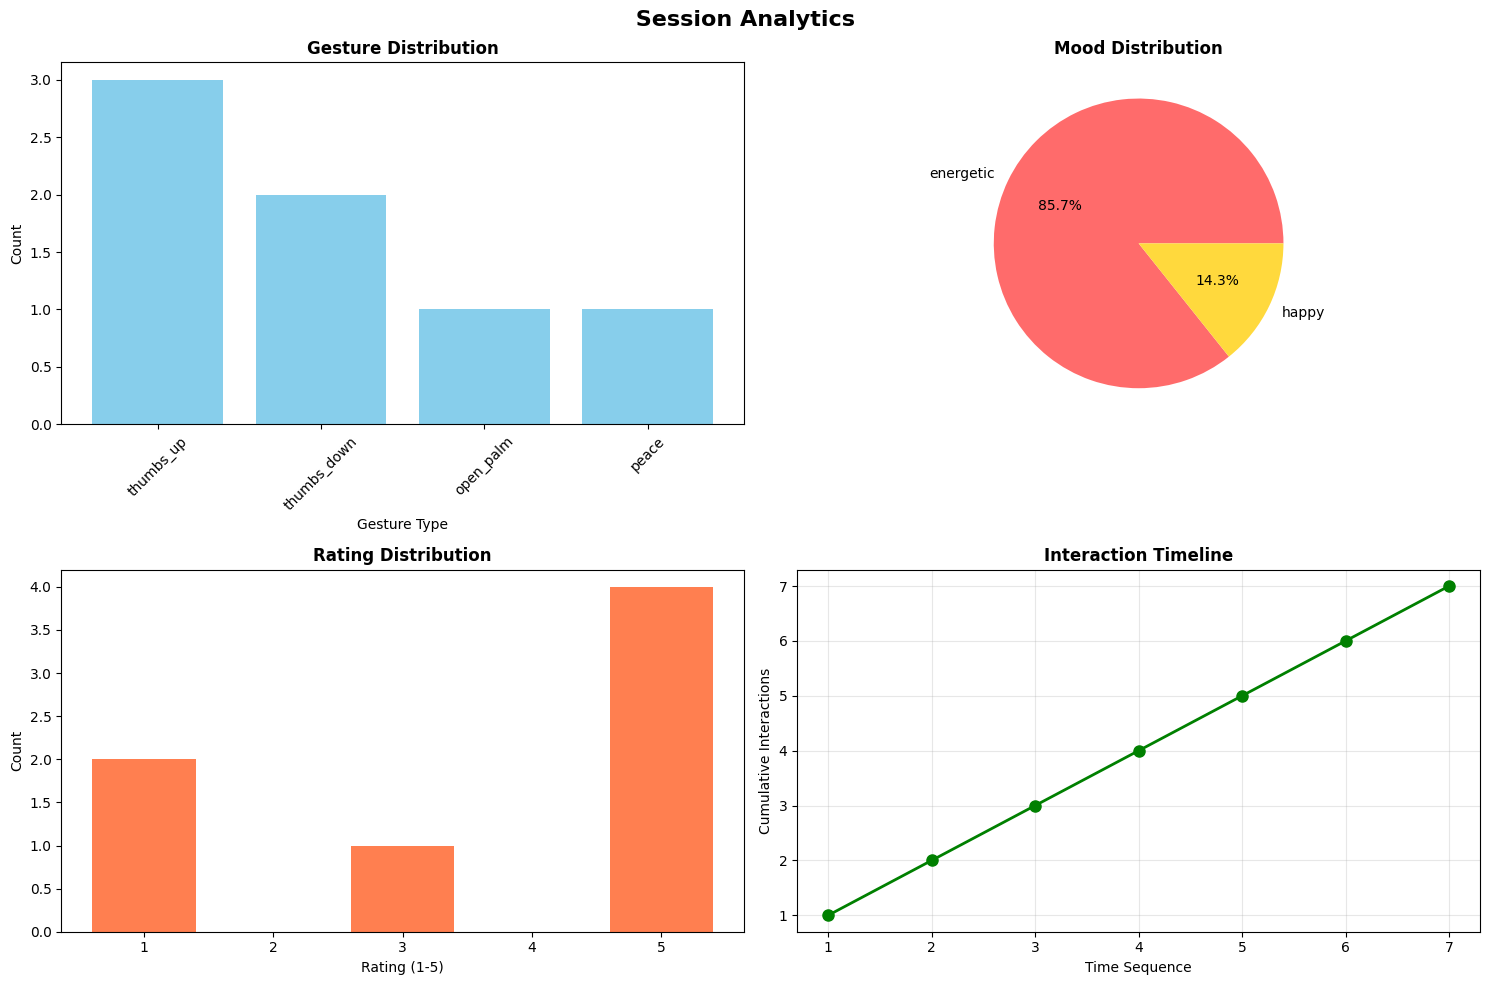


DETAILED ANALYTICS

🎵 Total Songs Interacted: 6
🎤 Unique Artists: 6
⭐ Average Rating: 3.57/5.00
👍 Most Used Gesture: thumbs_up
🎭 Dominant Mood: energetic

🎵 Most Interacted Songs:
   My Way                                   - Limp Bizkit          (2x)
   Back From The Dead - Original Mix        - Paul Elstak;Partyrai (1x)
   Envolver                                 - Anitta               (1x)
   Go Tell It On The Mountain / Ain't No Mo - Gregory Porter;Anita (1x)
   No Sleep                                 - The Grogans          (1x)


In [33]:
# visualizing results
"""Creates visualizations of the session"""

def visualize_session(session):

    if not session['interactions']:
        print(" No interactions to visualize!")
        return
    
    df = pd.DataFrame(session['interactions'])
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(' Session Analytics ', 
                 fontsize=16, fontweight='bold')
    
    # 1. Gesture distribution
    gesture_counts = df['gesture'].value_counts()
    axes[0, 0].bar(gesture_counts.index, gesture_counts.values, color='skyblue')
    axes[0, 0].set_title('Gesture Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Gesture Type')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Mood distribution
    mood_counts = df['mood'].value_counts()
    colors = ['#ff6b6b', '#ffd93d', '#6bcf7f', '#4d96ff', '#a8dadc']
    axes[0, 1].pie(mood_counts.values, labels=mood_counts.index, 
                   autopct='%1.1f%%', colors=colors[:len(mood_counts)])
    axes[0, 1].set_title('Mood Distribution', fontsize=12, fontweight='bold')
    
    # 3. Rating distribution
    rating_counts = df['rating'].value_counts().sort_index()
    axes[1, 0].bar(rating_counts.index, rating_counts.values, color='coral')
    axes[1, 0].set_title('Rating Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Rating (1-5)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_xticks([1, 2, 3, 4, 5])
    
    # 4. Interactions timeline
    df['interaction_num'] = range(1, len(df) + 1)
    axes[1, 1].plot(df['interaction_num'], df['interaction_num'], 
                    marker='o', color='green', linewidth=2, markersize=8)
    axes[1, 1].set_title('Interaction Timeline', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Time Sequence')
    axes[1, 1].set_ylabel('Cumulative Interactions')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed stats
    print("\n" + "="*70)
    print("DETAILED ANALYTICS")
    print("="*70)
    print(f"\n🎵 Total Songs Interacted: {df['song_id'].nunique()}")
    print(f"🎤 Unique Artists: {df['artist'].nunique()}")
    print(f"⭐ Average Rating: {df['rating'].mean():.2f}/5.00")
    print(f"👍 Most Used Gesture: {df['gesture'].mode()[0]}")
    print(f"🎭 Dominant Mood: {df['mood'].mode()[0]}")
    
    print("\n🎵 Most Interacted Songs:")
    song_counts = df.groupby(['song_name', 'artist']).size().sort_values(ascending=False).head(5)
    for (song, artist), count in song_counts.items():
        print(f"   {song[:40]:40s} - {artist[:20]:20s} ({count}x)")
    
    print("="*70)


# VISUALIZE
visualize_session(session_data)

    EXPORTING SESSION INTERACTIONS FOR PESONALIZED RECOMMENDATIONS

In [34]:
# EXPORT SESSION DATA

def export_session(session, filename='user_preferences.csv'):
    """Export session data to CSV"""
    
    if not session['interactions']:
        print(" No data to export!")
        return
    
    df = pd.DataFrame(session['interactions'])
    df.to_csv(filename, index=False)
    
    print(f" Exported {len(df)} interactions to {filename}")
    print(f"\n File contains:")
    print(f"   - Song names and artists")
    print(f"   - Gestures and actions")
    print(f"   - Detected moods")
    print(f"   - Ratings")
    print(f"   - Timestamps")
    
    return df


# EXPORT
export_session(session_data).head(1)

 Exported 7 interactions to user_preferences.csv

 File contains:
   - Song names and artists
   - Gestures and actions
   - Detected moods
   - Ratings
   - Timestamps


,song_id,song_name,artist,gesture,action,mood,rating,timestamp
0,3IAfUEeaXRX9s9UdKOJrFI,Envolver,Anitta,thumbs_down,dislike,energetic,1,2026-01-17 21:11:25.763831


    PERSONALIZED SONG RECOMMENDATIONS USING GESTURES AND ANALYTICS

 Running live recommendations for 60 seconds...
Now Playing: I Wanna Be Yours by Arctic Monkeys
Next Recommendation: Bedroom Talk - LIVE by Official HIGE DANdism
Next Recommendation: Kaantha by K. S. Harisankar;Pragathi Band
Next Recommendation: Kaantha by K. S. Harisankar;Pragathi Band
Next Recommendation: Kriminologi by Skurken


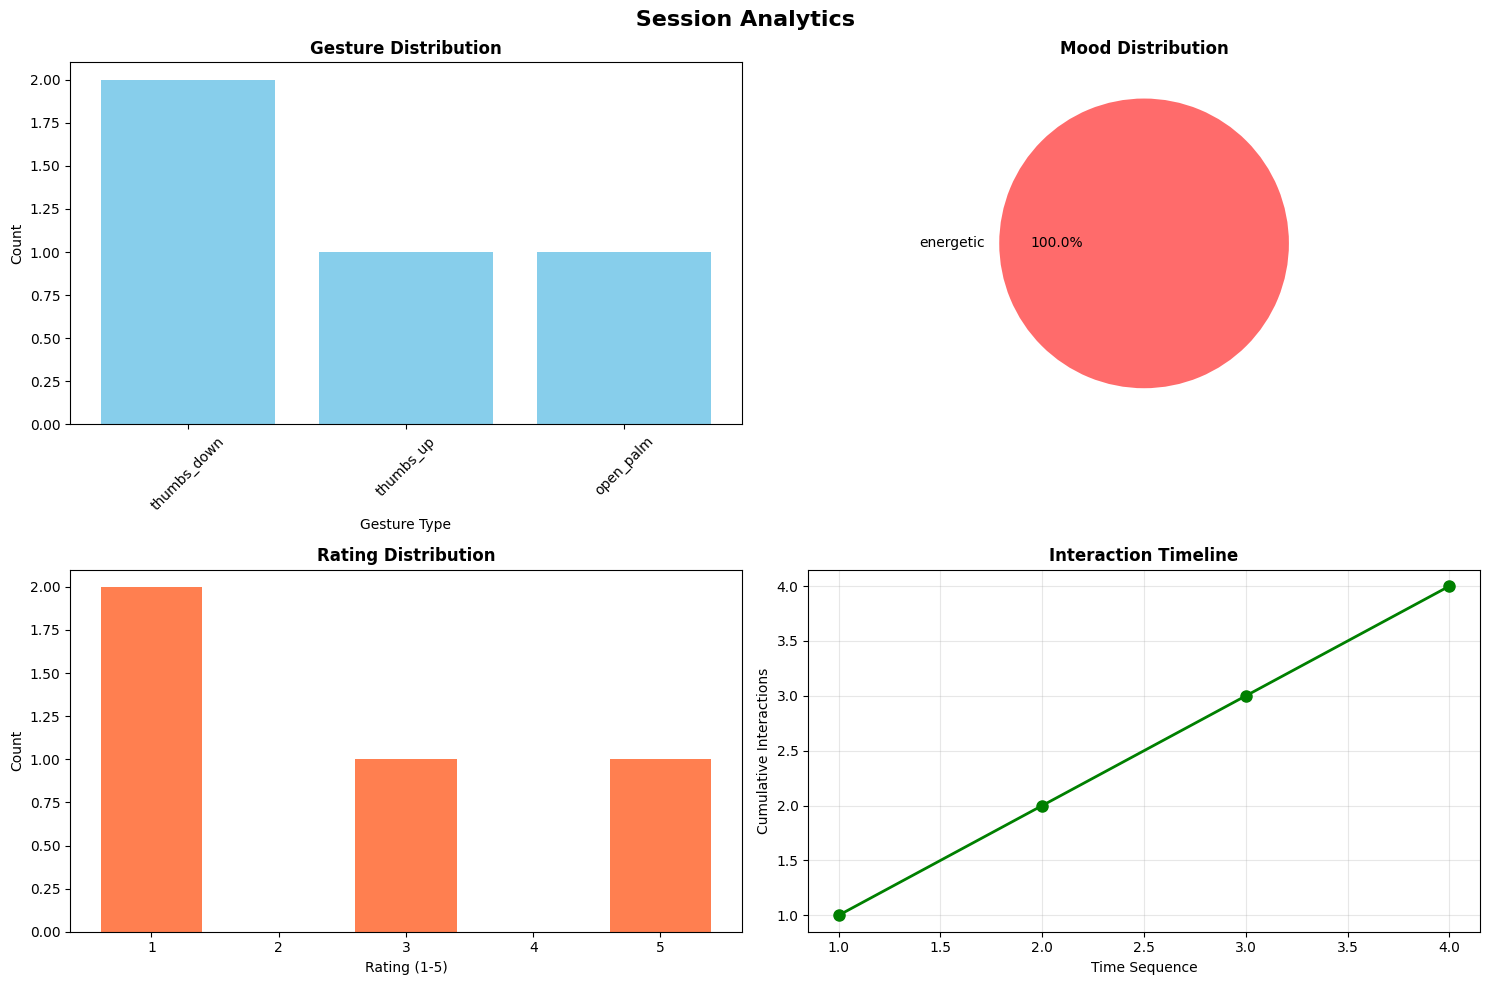


DETAILED ANALYTICS

🎵 Total Songs Interacted: 3
🎤 Unique Artists: 3
⭐ Average Rating: 2.50/5.00
👍 Most Used Gesture: thumbs_down
🎭 Dominant Mood: energetic

🎵 Most Interacted Songs:
   Kaantha                                  - K. S. Harisankar;Pra (2x)
   Bedroom Talk - LIVE                      - Official HIGE DANdis (1x)
   I Wanna Be Yours                         - Arctic Monkeys       (1x)


In [36]:
"""
    Real-time mood-based music recommendations using webcam gestures.
"""

def live_mood_recommendations(duration=30):
    
    print(f" Running live recommendations for {duration} seconds...")
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("!! Cannot access webcam !!")
        return
    
    # Start session
    live_session = {
        'liked_songs': [],
        'disliked_songs': [],
        'current_song': None,
        'interactions': []
    }
    
    start_time = time.time()
    last_gesture = None
    current_mood = "neutral"
    
    # Initial recommendation
    initial_recs = recommender.content_based_recommend([], MOOD_FEATURES['neutral'], 1)
    if initial_recs:
        live_session['current_song'] = initial_recs[0]
        print(f"Now Playing: {initial_recs[0]['song_name']} by {initial_recs[0]['artist']}")
    
    while time.time() - start_time < duration:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Detect gesture & mood
        processed_frame, gesture, mood, confidence = detector.process_frame(frame)
        
        if mood:
            current_mood = mood
        
        # Display info
        cv2.putText(processed_frame, f"Mood: {current_mood}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        if live_session['current_song']:
            cv2.putText(processed_frame, f"Playing: {live_session['current_song']['song_name'][:35]}", 
                        (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        if gesture:
            cv2.putText(processed_frame, f"Gesture: {gesture}", (10, 90), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        cv2.imshow("Live MoodTune", processed_frame)
        
        # Process gesture if new
        if gesture and gesture != last_gesture and live_session['current_song']:
            action = GESTURE_ACTIONS.get(gesture)
            song = live_session['current_song']
            
            # Update session
            if action in ['like', 'favorite']:
                live_session['liked_songs'].append(song['song_id'])
                rating = 5
            elif action == 'dislike':
                live_session['disliked_songs'].append(song['song_id'])
                rating = 1
            else:
                rating = 3  # skip
            
            live_session['interactions'].append({
                'song_id': song['song_id'],
                'song_name': song['song_name'],
                'artist': song['artist'],
                'gesture': gesture,
                'action': action,
                'mood': current_mood,
                'rating': rating,
                'timestamp': datetime.now()
            })
            
            # Get next recommendation based on mood + liked songs
            mood_features = MOOD_FEATURES.get(current_mood, MOOD_FEATURES['neutral'])
            recs = recommender.content_based_recommend(
                live_session['liked_songs'], mood_features, 5
            )
            
            # Filter out already interacted songs
            interacted = set(live_session['liked_songs'] + live_session['disliked_songs'])
            recs = [r for r in recs if r['song_id'] not in interacted]
            
            if recs:
                live_session['current_song'] = recs[0]
                print(f"Next Recommendation: {recs[0]['song_name']} by {recs[0]['artist']}")
            
            last_gesture = gesture
        
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     print("Stopped by user")
        #     break
    
    cap.release()
    cv2.destroyAllWindows()
    
    return live_session

if __name__ == "__main__":
    session_data = live_mood_recommendations(60)  # 1-minute session
    visualize_session(session_data)
    # export_session(session_data)



    6) Ethical Considerations & Responsible AI

a) Bias & Fairness :

 >Recommendations depend on dataset availability

 >Genre and popularity bias may exist

 >No demographic profiling is performed

b) Dataset Limitations :

 >Spotify dataset does not represent all music cultures

 >Audio features are numerical approximations of emotion

 >No strict user emotion labels

c) Responsible Use of AI Tools

 >AI used only for educational purposes

 >No personal data is stored

 >No facial recognition or identity tracking

 >Webcam access is user-controlled

 


    7) Conclusion & Future Scope

a) Summary of Results

The system successfully:

 >Detects hand gestures in real time

 >Infers user mood dynamically

 >Generates personalized music recommendations

 >Logs and visualizes user interactions

b) Future Improvements

 >Multi-user collaborative learning

 >Mobile or web deployment

 >Integration with Spotify API

 >Voice + gesture multimodal input
 